In [151]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [152]:
# Set the style
sns.set()

In [153]:
# We need the original (pre-encoding) dataframe for this, so let's reload it.
# Or, you can just run this before your encoding cell.
insurance_dataset = pd.read_csv('data/insurance.csv')

/home/nandanv76/.local/lib/python3.14/site-packages/seaborn/_base.py:1447: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.plot_data[axis] = cat_data
/home/nandanv76/.local/lib/python3.14/site-packages/seaborn/categorical.py:415: FutureWa

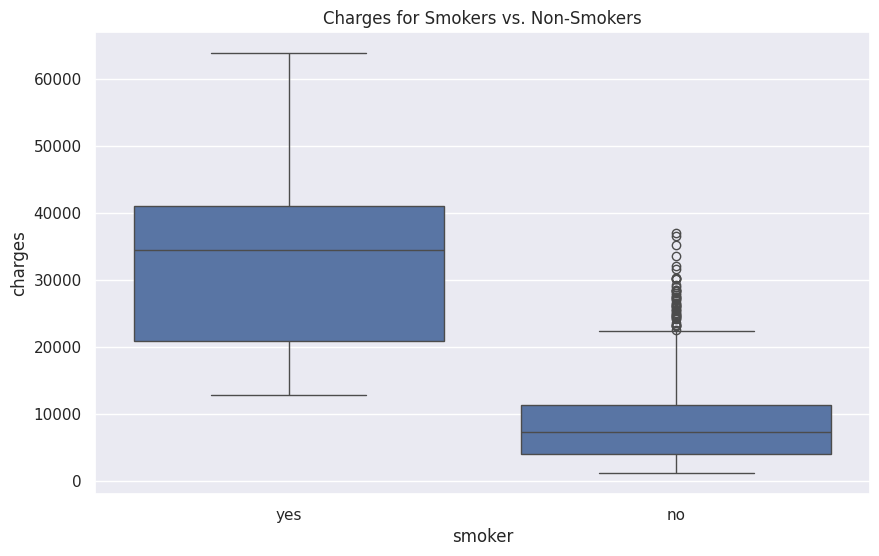

In [154]:
# 1. How does smoking affect charges? (Categorical vs. Numerical)
plt.figure(figsize=(10, 6))
sns.boxplot(x='smoker', y='charges', data=insurance_dataset)
plt.title('Charges for Smokers vs. Non-Smokers')
plt.show()

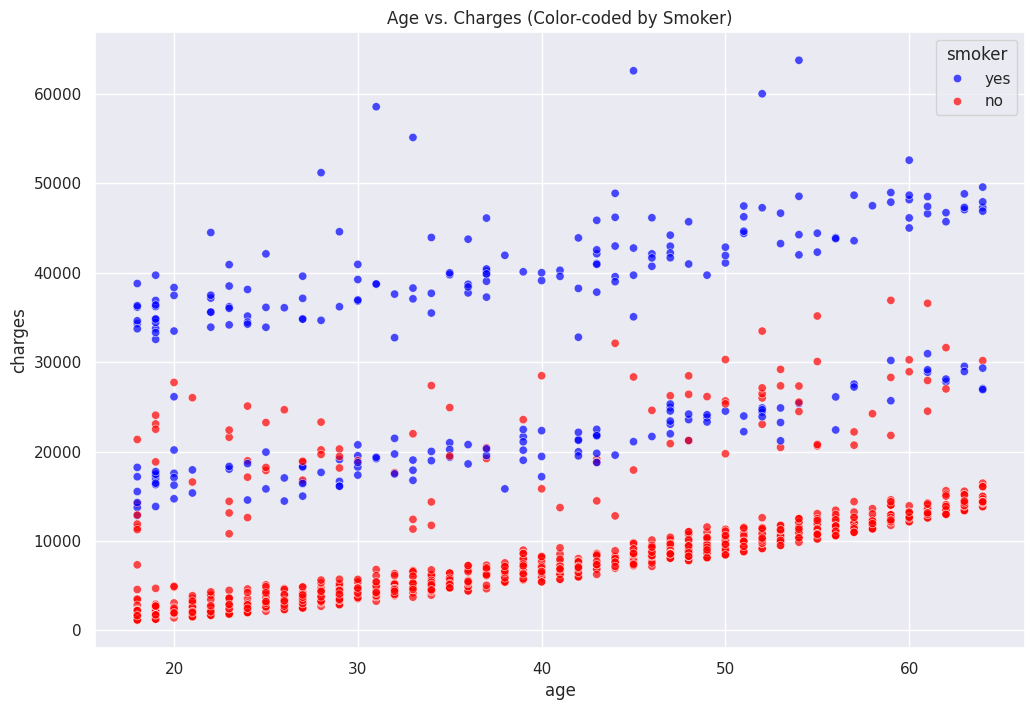

In [155]:
# 2. How does age relate to charges? (Numerical vs. Numerical)
# We can also see how smoking interacts with age and charges
plt.figure(figsize=(12, 8))
sns.scatterplot(x='age', y='charges', data=insurance_dataset, hue='smoker', palette=['blue', 'red'], alpha=0.7)
plt.title('Age vs. Charges (Color-coded by Smoker)')
plt.show()

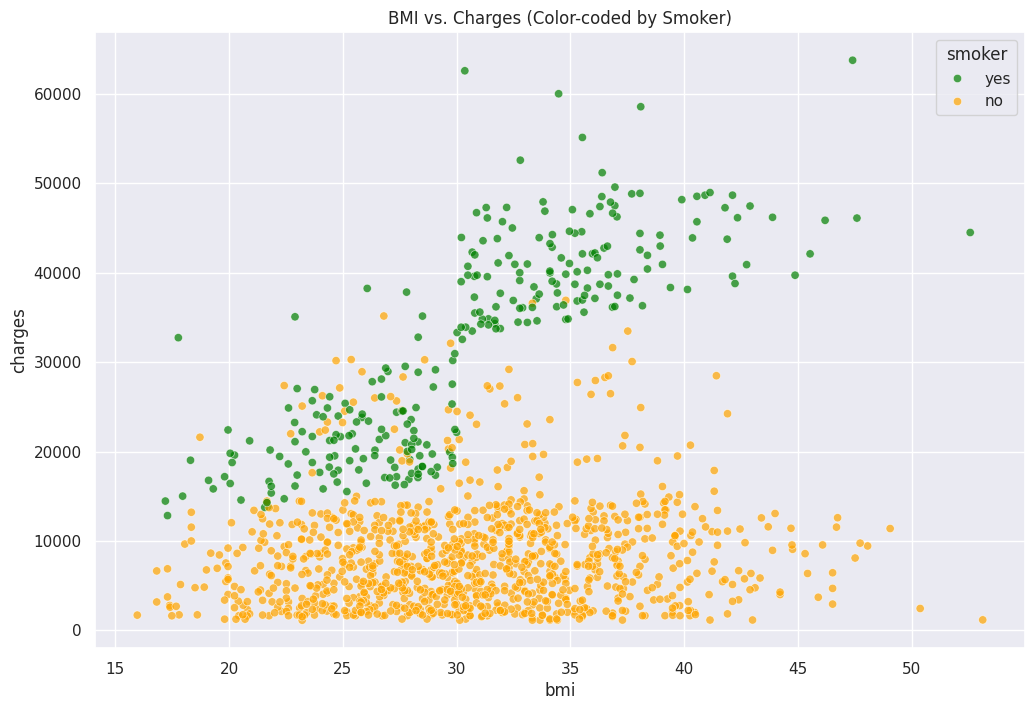

In [156]:
# 3. How does BMI relate to charges?
# This plot is famous for this dataset - it shows clear "clusters"
plt.figure(figsize=(12, 8))
sns.scatterplot(x='bmi', y='charges', data=insurance_dataset, hue='smoker', palette=['green', 'orange'], alpha=0.7)
plt.title('BMI vs. Charges (Color-coded by Smoker)')
plt.show()

/tmp/ipykernel_204128/2244413493.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_data.replace({'sex':{'male':0,'female':1}}, inplace=True)
/tmp/ipykernel_204128/2244413493.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  encoded_data.replace({'smoker':{'yes':0,'no':1}}, inplace=True)
/tmp/ipykernel_204128/2244413493.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to 

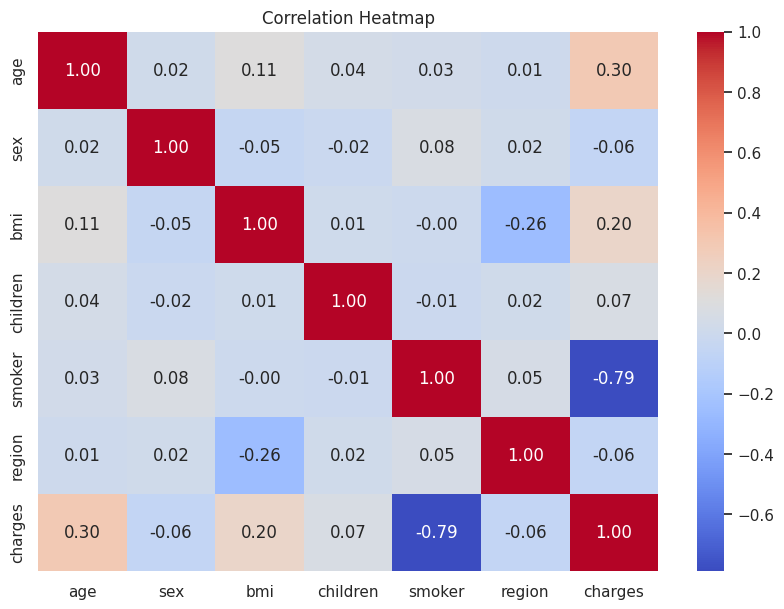

In [157]:
# 4. Correlation Heatmap
# This shows the linear relationship between all numerical features
encoded_data = insurance_dataset.copy() 
encoded_data.replace({'sex':{'male':0,'female':1}}, inplace=True)
encoded_data.replace({'smoker':{'yes':0,'no':1}}, inplace=True)
encoded_data.replace({'region':{'southeast':0,'southwest':1,'northeast':2,'northwest':3}}, inplace=True)
plt.figure(figsize=(10, 7))
sns.heatmap(encoded_data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [158]:
# --- Splitting the Features and Target ---
# We use the original dataframe BEFORE we did any manual .replace()
X = insurance_dataset.drop(columns='charges', axis=1)
Y = insurance_dataset['charges']

In [159]:
# --- Splitting the data into Training & Testing ---
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [160]:
# --- Building the Pre-processing Pipeline ---
# First, we define which columns are which type
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

In [161]:
# Create the transformer for NUMERIC features
# This will scale them (e.g., make 'age' and 'bmi' play nice)
numeric_transformer = StandardScaler()

In [162]:
# Create the transformer for CATEGORICAL features
# This will perform One-Hot Encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [163]:
# Create a "ColumnTransformer" to apply the right transformer to the right column
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [164]:
# --- Let's check what the preprocessor does ---
# This is an optional step, but good for understanding
print("--- Preprocessing Example ---")
X_train_transformed = preprocessor.fit_transform(X_train)
print(f"Original data shape: {X_train.shape}")
print(f"Transformed data shape: {X_train_transformed.shape}")
print("\nThis new shape is because 'sex'(2), 'smoker'(2), and 'region'(4) were one-hot encoded.")
print("3 (numeric) + 2 (sex) + 2 (smoker) + 4 (region) = 11 columns")

--- Preprocessing Example ---
Original data shape: (1070, 6)
Transformed data shape: (1070, 11)

This new shape is because 'sex'(2), 'smoker'(2), and 'region'(4) were one-hot encoded.
3 (numeric) + 2 (sex) + 2 (smoker) + 4 (region) = 11 columns


--- Model Training ---

In [165]:
# We create a dictionary of models we want to try
# Each model is a Pipeline that contains:
# 1. Our 'preprocessor' from above
# 2. The model (regressor) itself
models = {
    "Linear Regression": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    
    "Random Forest": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ]),
    
    "Gradient Boosting": Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(random_state=42))
    ])
}

--- Model Evaluation ---

In [166]:
# We will store the results here
results = {}

In [167]:
print("\n--- Model Training & Evaluation ---")


--- Model Training & Evaluation ---


In [168]:
for name, model in models.items():
    # Fit the model
    model.fit(X_train, Y_train)
    
    # Make predictions on the test set
    Y_pred = model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(Y_test, Y_pred)
    mae = mean_absolute_error(Y_test, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    
    # Store and print results
    results[name] = {'R-squared': r2, 'MAE': mae, 'RMSE': rmse}
    
    print(f"--- {name} ---")
    print(f"  R-squared: {r2:.4f}")
    print(f"  Mean Absolute Error (MAE): ${mae:,.2f}")
    print(f"  Root Mean Squared Error (RMSE): ${rmse:,.2f}\n")

--- Linear Regression ---
  R-squared: 0.7449
  Mean Absolute Error (MAE): $4,279.86
  Root Mean Squared Error (RMSE): $6,189.09

--- Random Forest ---
  R-squared: 0.8404
  Mean Absolute Error (MAE): $2,714.47
  Root Mean Squared Error (RMSE): $4,895.51

--- Gradient Boosting ---
  R-squared: 0.8686
  Mean Absolute Error (MAE): $2,352.42
  Root Mean Squared Error (RMSE): $4,442.73



In [169]:
# --- Find the best model ---
best_model_name = max(results, key=lambda name: results[name]['R-squared'])
best_model_pipeline = models[best_model_name]

In [170]:
print(f"--- Best Model ---")
print(f"The best model based on R-squared is: {best_model_name}")
print(f"Its R-squared on the test set is: {results[best_model_name]['R-squared']:.4f}")

--- Best Model ---
The best model based on R-squared is: Gradient Boosting
Its R-squared on the test set is: 0.8686


--- Building a Predictive System ---

In [171]:
# We use the 'best_model_pipeline' we found in the previous step
print(f"\n--- Using the Best Model ({best_model_name}) for a New Prediction ---")


--- Using the Best Model (Gradient Boosting) for a New Prediction ---


In [172]:
# Let's create a new person to predict.
# We use the original, human-readable data
new_person_data = {
    'age': 31,
    'sex': 'female',
    'bmi': 25.74,
    'children': 0,
    'smoker': 'no',
    'region': 'southeast'
}

In [173]:
# Convert this data into a DataFrame, because our pipeline expects it!
# This is much more robust than the numpy reshape.
new_person_df = pd.DataFrame([new_person_data])

In [174]:
# Use the pipeline to predict
# The pipeline AUTOMATICALLY applies all the scaling and one-hot encoding
# just as it did for the training data.
predicted_cost = best_model_pipeline.predict(new_person_df)

In [175]:
print(f"Data for new person:\n{new_person_df.to_markdown(index=False)}")
print("---------------------------------")
print(f"Predicted Insurance Cost: ${predicted_cost[0]:,.2f}")

Data for new person:
|   age | sex    |   bmi |   children | smoker   | region    |
|------:|:-------|------:|-----------:|:---------|:----------|
|    31 | female | 25.74 |          0 | no       | southeast |
---------------------------------
Predicted Insurance Cost: $3,975.44
